# Data Processing - Feature extraction

This jupiter notebook is one of the two main notebooks for the project. <br>

The goals are to import all the wave data, preprocess them (filter and segment if needed), extract features and save those features as .csv file which can then be imported as dataframe for the ML part.

In [1]:
#imports
import scipy
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn


from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import iirnotch
from scipy.signal import welch
import warnings
warnings.filterwarnings("ignore")


import statistics
import math
import os

### <u> <b> 1. Import data

In [2]:
# Import function:
def import_data(subject,motion,side, wave):
    
    #input: subject nbr, motion nbr, side(r or l)
    #returns: corresponding EMG and IMU files

    data_dir = "cut_data/s" + str(subject) + "/s" + str(subject) + "_m" + str(motion) + "_" + side + "_w" + str(wave) + ".csv" 
    
    data = pd.read_csv(data_dir)
    
    data = data.drop(columns=['x_rot', 'y_rot','z_rot'])
    
    return data


#For visualisation:
def plot_sample(wave_frame):
    
    labels = ['time', 'ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc'] 
    
    t = wave_frame.time
    
    fig, axs = plt.subplots(7,figsize=(16,9))
    axs[0].plot(t,wave_frame.ch1)
    axs[1].plot(t,wave_frame.ch2)
    axs[2].plot(t,wave_frame.ch3)
    axs[3].plot(t,wave_frame.ch4)
    axs[4].plot(t,wave_frame.x_acc)
    axs[5].plot(t,wave_frame.y_acc)
    axs[6].plot(t,wave_frame.z_acc)
    
    
    for k in range(0,7):
        axs[k].set_ylabel(labels[k+1])
        axs[k].grid()
    
    plt.show()

In [3]:
#Define constants:
fs = 512 #Hz  (sample frequency)

#Import the data at subject,motion,side:

subject_number = 2
motion_number = 6
side = 'r' #please use 'r' or 'l'
wave_number = 3



sample = import_data(subject_number,motion_number,side, wave_number)


In [4]:
sample

,Unnamed: 0,time,ch1,ch2,ch3,ch4,x_acc,y_acc,z_acc
0,0,0.000000,-2.061380,3.419142,1.357762,4.749137,1.751730,1.071887,11.194787
1,1,0.001953,-2.061380,3.424119,1.362738,4.766951,1.758974,1.069472,11.191165
2,2,0.003906,-2.045442,3.427003,1.381562,4.782529,1.766219,1.067058,11.187543
3,3,0.005859,-2.044360,3.415825,1.371465,4.806257,1.775187,1.063206,11.182196
4,4,0.007812,-2.039383,3.356613,1.317229,4.749498,1.789676,1.054754,11.171330
...,...,...,...,...,...,...,...,...,...
1531,1531,2.990234,-2.050129,3.391520,1.341390,4.767095,1.513091,0.708743,10.923516
1532,1532,2.992188,-2.057269,3.392313,1.335043,4.662086,1.507054,0.702706,10.918687
1533,1533,2.994141,-2.057774,3.401689,1.343914,4.697570,1.501017,0.696669,10.913857
1534,1534,2.996094,-2.049841,3.390438,1.340597,4.720144,1.491968,0.690632,10.931115


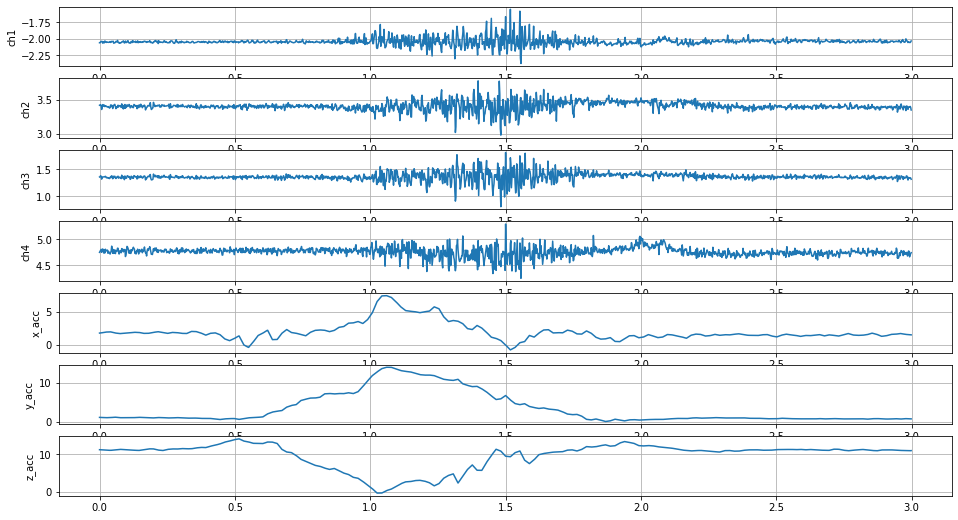

In [5]:
plot_sample(sample)

### <u> <b> 2. Data pre-processing

In [6]:
def EMG_bp_filtering(signal,fs):
    
    #input: EMG signal and sample frequency
    #returns: bp-filtered EMG signal (cutoff defined here)
    
    low = 20 #Hz
    high = 250 #Hz
    cutoff = [low,high] #cutoff frequencies 

    num_bp, den_bp = butter(3, cutoff, 'bandpass',analog=False,fs=fs) #bandpass definition
    signal_filtered = filtfilt(num_bp, den_bp,signal) #application of the bandpass on the signal
    
    return signal_filtered


def EMG_notch_filtering(signal,fs):
    
    #input: EMG signal and sample frequency
    #returns: notch-filtered EMG signal (cutoff defined here)
    
    cutoff = 50 #Hz
    Quality = cutoff/3 #as defined by scipy for a -3dB notch
    
    num_notch, den_notch = scipy.signal.iirnotch(cutoff,Quality,fs)
    signal_filtered = filtfilt(num_notch, den_notch,signal) #application of the bandpass on the signal
    
    return signal_filtered


#Main EMG filtering function (bp and notch)
def EMG_filtering(signal,fs):

    #input: EMG signal (1 channel)
    #returns: filtered EMG-channel

    bp_filt_sig = EMG_bp_filtering(signal,fs)
    
    filt_sig = EMG_notch_filtering(bp_filt_sig,fs)
    
    return filt_sig


### <u> <b> 3. Feature extraction

In [7]:
def square_sig(sig):
    
    sqd_sig = []
    
    for t in sig:
        sqd_sig.append(t**2)

    return sqd_sig


In [8]:
def MAV(signal):
    
    abs_signal = [abs(val) for val in signal]
    
    mean = statistics.mean(abs_signal)
    
    return mean

In [9]:
def WL(signal): #(Chan et al., 2021)
    
    dif = []
    
    for t in range(0,len(signal)-2):
        
        dif.append(abs(signal[t+1]-signal[t]))
        
    waveform_length = sum(dif)
    
    return waveform_length
        

In [10]:
def RMS(signal): #(Phinyomark et al., 2014)
    
    sqrd_sig = square_sig(signal)
    
    rms = math.sqrt(sum(sqrd_sig)/len(sqrd_sig))
    
    return rms
    

In [11]:
def ZCR(signal): #(Torres-Garcia et al., 2022)
    
    ZCR = 0 #set the count at 0
    
    e = 0.001 * max(signal) #we take 0.1% of the max value as threshold
    
    for t in range(0,len(signal)-1):
        
        cond1 = ((signal[t]< 0) and (signal[t+1] > 0))
        cond2 = ((signal[t]> 0) and (signal[t+1] < 0))
        
        cond_e = (abs(signal[t]-signal[t+1]) >= e)
        
        if((cond1 or cond2) and cond_e):
            ZCR += 1
            
    return ZCR

In [12]:
def WAMP(signal,fs): #(Phinyomark et al., 2014)
    
    #following threshold definition by (Warris et al., 2018):
    
    #get the first 0.5s of the signal:
    rest_sig =  signal[0:round(fs/2)]
    
    #get the threshold as the RMS of the rest signal:
    e = RMS(rest_sig)
    
    #then calculate WAMP:
    
    def f(a):

        if a < e:
            return 1
        else:
            return 0
    
    WAMP = 0 #set the count at 0
    
    for i in range(0,len(signal)-1):
         
        WAMP += f(abs(signal[i+1]-signal[i]))
    
    return WAMP

In [13]:
def SSC(signal,fs): #(Torres et al., 2022):
    
    #get the first 0.5s of the signal:
    rest_sig =  signal[0:round(fs/2)]
    
    #get the threshold as the RMS of the rest signal:
    e = 0.1*RMS(rest_sig)
    
    count = 0
    
    for i in range(1,len(signal)-1):
        
        condition = (signal[i] > signal[i-1] and signal[i] > signal[i+1]) or (signal[i] < signal[i-1] and signal[i] < signal[i+1])
        
        thres_condition = (abs(signal[i]-signal[i+1]) >= e) or (abs(signal[i]-signal[i-1])<=e)
        
        if condition and thres_condition:
            count += 1
            
    return count   

In [14]:
def VAR(signal): #(Phinyomark et al., 2014)
    
    sqrd_sig = square_sig(signal)
    
    var = 1/(len(sqrd_sig)-1) * sum(sqrd_sig)
    
    return var

#### <u> Frequency Domain

In [15]:
def resonance_frequency(fourier_signal):
    
    res_frq = np.max(fourier_signal)
    
    return res_frq

In [16]:
def frequency_domain(signal,fs):

    #input: signal (one channel) and sample frequency
    #returns: 

    #to work in the frequency domain, it is usefull to use the fourier transform

    fourier_signal = np.fft.rfft(signal)

    freq_signal = np.fft.rfftfreq(signal.size, d=1./fs) #needed for the plot



    #and then find the features:

    #resonance frequency
    #res_frq = resonance_frequency(fourier_signal)
    
    
    
    #we may also want to print the signal in fourier domain but this should not be automatic, thus a bool input
    #was added to allow to decide when this plotting should occur and when not:

    plot_freq = False
    
    if plot_freq == True:
        
        fig = plt.figure(figsize=(16, 3)) #define the figure
        plt.plot(freq_signal,abs(fourier_signal))
        plt.grid()
        plt.xlabel("Frequency (in Hz)")
        plt.ylim([-1,20])
        plt.show()


    return fourier_signal,freq_signal

In [17]:
def fourier_plot(waveframe,fs):
    
    #input: waveframe (7signals: 4EMG, 3IMU)
    #returns: plots
    
    labels = ['time', 'ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc'] 
    
    #transform each in f-domain:
    f_signals = []
    freqs = []
    
    for k in range(1,len(labels)):
        filt_sig = EMG_filtering(waveframe[labels[k]],fs)
        f_sig_k,freq_k = frequency_domain(filt_sig,fs)
        
        f_signals.append(abs(f_sig_k))
        freqs.append(freq_k)
    
    #plot:
    fig, axs = plt.subplots(7,figsize=(16,9))
    axs[0].plot(freqs[0],f_signals[0])
    axs[1].plot(freqs[1],f_signals[1])
    axs[2].plot(freqs[2],f_signals[2])
    axs[3].plot(freqs[3],f_signals[3])
    axs[4].plot(freqs[4],f_signals[4])
    axs[5].plot(freqs[5],f_signals[5])
    axs[6].plot(freqs[6],f_signals[6])
    
    for k in range(0,7):
        axs[k].set_ylabel(labels[k+1])
        axs[k].grid()
    
    

In [18]:
def mean_frequency(f_sig,freq_sig): #(Chan et al., 2021)
    
    #input: signal filtered and in fourier domain and freq signal
    #returns: mean frequency
    
    L = sum(abs(np.real(f_sig)))
    
    powers = []
    for k in range(0,len(f_sig)):
        powers.append(abs(np.real(f_sig[k]))*freq_sig[k])
        
    power_sum = sum(powers)
    
    f_mean = power_sum/L
    
    return f_mean

In [19]:
def median_frequency(f_sig,freq_sig): #(Chan et al., 2021):
    
    #input: signal filtered and in fourier domain and freq signal
    #returns: median frequency
    
    powers = []
    for k in range(0,len(f_sig)):
        powers.append(abs(np.real(f_sig[k])))
        
    power_sum = sum(powers)
    
    median_idx = int(power_sum/2)
    
    print(median_idx)
    
    f_median = freq_sig[median_idx]
    
    return f_median

In [20]:
def PSD(signal,fs):
    psd_sig = welch(signal, fs)
    PSD_idx = np.where(psd_sig[1] == max(psd_sig[1]))
    PSD = psd_sig[0][PSD_idx[0][0]]
    
    
    return PSD

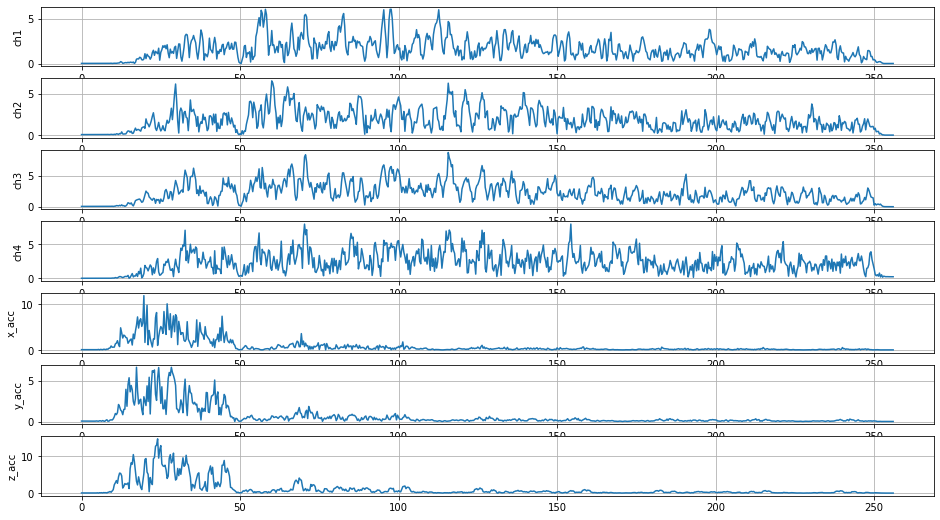

In [21]:
fourier_plot(sample,fs)

## <u> <b> 4. Apply the process

### <u> <b> 4.1 Define functions

In [22]:
filepath_list = [] #define an empty list to store the filenames

subject_list = [] 
motion_list = []
side_list = []
wave_list = []


def get_file_of_subject(subject_nbr):
    
    #input: subject number as list
    #returns: fills up the predefined list for filepath, subjects, motions, sides and waves
    
    for sub_nbr in subject_nbr:
        directory = 'cut_data/s'+str(sub_nbr)
        
        for filename in os.listdir(directory): #go through all the data
            if filename != '.ipynb_checkpoints':
                #it happens often that jupiter notebook saves chekpoints which in turn break the code, 
                #so just to avoid that issue
                f = os.path.join(directory, filename)  
                filepath_list.append(f)
                subject_list.append(sub_nbr)

                #check the side
                if 'r' in f:
                    side_list.append('r')
                elif 'l' in f:
                    side_list.append('l')

                #check the motion
                for idx in range(1,9):

                    if 'm' + str(idx) in f:
                        motion_list.append(idx)

                #check the wave
                for idx in range(1,11):   
                    if ('w' + str(idx) in f) & ('w10' not in f):
                        wave_list.append(idx)

                    if (idx==10) & ('w' + str(idx) in f):
                        wave_list.append(idx)
                                  

In [23]:
def feature_def(feat_name,filt_sig,fs):
    
    #input: name of the feature, filtered input signal, and sample frequency(for the f-domain)
    #return: desired feature of the signal

    #t-domain:
    if feat_name == 'MAV':
        return MAV(filt_sig)
    
    if feat_name == 'WL':
        return WL(filt_sig)
    
    if feat_name == 'RMS':   
        return RMS(filt_sig)
    
    if feat_name == 'ZCR':
        return ZCR(filt_sig)
    
    if feat_name == 'WAMP':
        return WAMP(filt_sig,fs)
    
    if feat_name == 'SSC':
        return SSC(filt_sig,fs)
    
    if feat_name == 'VAR':
        return VAR(filt_sig)
    
    
    #f-domain:
    if feat_name == 'mean_freq':
        wave_f,wave_ff = frequency_domain(filt_sig,fs)
        return mean_frequency(wave_f,wave_ff)
    
    if feat_name == 'median_freq':
        wave_f,wave_ff = frequency_domain(filt_sig,fs)
        return median_frequency(wave_f,wave_ff)
    
    if feat_name == 'PSD':
        return PSD(filt_sig,fs)
                

In [24]:
def get_all_features(list_of_files,fs,labels,features):
    
    #input: list of file paths
    #returns: one list for each defined feature
    
    labels = labels
    
    all_features_list = [] #initialise all_features_list

    for k in range(len(features)):
        all_features_list.append([]) #and create one column for each feature
        
    
    for file in list_of_files: #go over all files
         
        #import the datafile of the wave:
        wave = pd.read_csv(file)
        
        feat_of_sig = []
        for k in range(len(features)):
            feat_of_sig.append([]) #and create one column for each signal

        for lab in labels:

            #first filter the signal:
            filt_sig = EMG_filtering(wave[lab],fs)
            
            #extract its features:
            for feat_idx in range(0,len(features)):
                
                feature_at_idx = feature_def(features[feat_idx],filt_sig,fs)
                
                feat_of_sig[feat_idx].append(feature_at_idx)

        #save the features of the signal in all_features   
        for x in range(0,len(features)):
            all_features_list[x].append(feat_of_sig[x])
                
            
    return all_features_list


In [25]:
def create_full_frame(filepath_list,fs,labels,features):
    
    #input: list with all the file paths
    #returns: dataframe with all labels and features , and list of the features
    
    #we get the features:
    all_features = get_all_features(filepath_list,fs,labels,features)
    
    #then we create the right labels for the columns:
    columns = ['subject','motion','side','wave']
    
    labels = labels
    
    features_labels=[]
    
    #save all the feature column names: (channel_feature)
    for lab in labels:
        for feat in features:
            features_labels.append(lab + '_' + feat)

        
    all_columns = columns + features_labels #all labels
    
    #create a list with full data:
    full_data=[subject_list,motion_list,side_list,wave_list]

    
    #then we create the right columns
    for k in range(0,len(labels)): #for each detailed label
        
        for x in range(0,len(features)):
            
            all_feat = []
            
            for sig in range(0,len(all_features[0])): #get the values for each wave
                
                feat_at_x = all_features[x]
                
                all_feat.append(feat_at_x[sig][k])
            
            
            #and add to full data   
            full_data.append(all_feat)
    
    #create a data dictionary:
    data_dictionary = {all_columns[0]:full_data[0]} #initiliase a dictionary with the labels

    for k in range(1,len(all_columns)):
        data_dictionary.update({all_columns[k]:full_data[k]}) #add all the values to the dictionary
    
    #make it into a dataframe:
    data_matrix = pd.DataFrame(data_dictionary) #and turn the dictionary into a dataframe
    
    
    return data_matrix,features_labels


### <u> <b> 4.2 Load data and extract features
    
You can define from which subjects and from which data labels (signals), which features should be extracted

In [26]:
subjects = [1,2,3,4]
labels = ['ch1','ch2','ch3', 'ch4','x_acc', 'y_acc', 'z_acc']
features = ['MAV','WL','RMS','ZCR','mean_freq']

get_file_of_subject(subjects)
data,features = create_full_frame(filepath_list,fs,labels,features)

### <u> <b> 4.3 Just some analysis

In [27]:
len(data[features[0]])

640

In [28]:
data[0:10]

,subject,motion,side,wave,ch1_MAV,ch1_WL,ch1_RMS,ch1_ZCR,ch1_mean_freq,ch2_MAV,...,y_acc_MAV,y_acc_WL,y_acc_RMS,y_acc_ZCR,y_acc_mean_freq,z_acc_MAV,z_acc_WL,z_acc_RMS,z_acc_ZCR,z_acc_mean_freq
0,1,1,r,5,0.026665,47.826458,0.056529,580,111.384875,0.033266,...,0.025688,15.602591,0.042556,143,43.515590,0.015768,9.895685,0.024681,154,47.472164
1,1,8,l,9,0.022671,39.107649,0.044605,637,108.124344,0.035943,...,0.020123,12.320689,0.039791,148,44.359142,0.018045,11.204617,0.028290,150,44.749926
2,1,8,l,8,0.024513,40.819198,0.060064,668,95.398184,0.035133,...,0.016543,10.620177,0.028893,155,46.720121,0.019272,13.483416,0.031947,166,52.286454
3,1,1,r,4,0.049217,89.644319,0.104085,600,112.549896,0.064270,...,0.032895,20.483694,0.058572,156,45.332813,0.023558,15.521021,0.036346,161,49.874775
4,1,1,r,10,0.015103,25.398991,0.027950,578,104.908335,0.020340,...,0.019292,11.907622,0.032414,160,43.917628,0.014538,9.238114,0.021658,148,48.806526
5,1,7,l,1,0.051520,106.921882,0.099692,679,134.693579,0.072204,...,0.028206,18.007223,0.050236,150,45.894633,0.029022,19.081986,0.053539,154,49.057872
6,1,6,l,1,0.016189,34.103649,0.031089,717,130.947920,0.054183,...,0.027910,17.628647,0.063508,152,44.828256,0.023239,15.331124,0.054872,158,47.267633
7,1,7,l,3,0.036713,75.876325,0.059879,679,133.610592,0.056519,...,0.035868,23.353482,0.056045,154,49.307737,0.027085,18.008030,0.046481,172,50.705298
8,1,6,l,3,0.019703,39.519689,0.031284,650,125.652451,0.048824,...,0.026918,16.834282,0.046543,151,46.498276,0.023215,15.223313,0.038619,176,46.892733
9,1,3,l,9,0.019292,33.040582,0.048119,618,109.739597,0.033322,...,0.019035,12.168062,0.032300,146,47.332075,0.015418,10.427921,0.025118,164,51.869784


## <u> <b> 5. Save dataframe as .csv 

In [29]:
#Save the "all-data with features" frame as .csv:

def save_to_csv(data_frame,feature_labels,name):
    
    #input: an all-data frame with all features ; a list of the labels of the features ; name to give to the feature frame
    #returns: saves all the features dataframe as .csv files with the intended name
    
    labels = pd.DataFrame(feature_labels, columns=['feature_labels'])
    
    labels_name = "features/" + name + "_labels.csv"
        
    name = "features/" + name + ".csv"
        
    labels.to_csv(labels_name)
    
    data_frame.to_csv(name)
        
    return

In [30]:
#save_to_csv(data,features,'optimised_WristOnly') #and save it as csv with intended name

In [31]:
data[0:10]

,subject,motion,side,wave,ch1_MAV,ch1_WL,ch1_RMS,ch1_ZCR,ch1_mean_freq,ch2_MAV,...,y_acc_MAV,y_acc_WL,y_acc_RMS,y_acc_ZCR,y_acc_mean_freq,z_acc_MAV,z_acc_WL,z_acc_RMS,z_acc_ZCR,z_acc_mean_freq
0,1,1,r,5,0.026665,47.826458,0.056529,580,111.384875,0.033266,...,0.025688,15.602591,0.042556,143,43.515590,0.015768,9.895685,0.024681,154,47.472164
1,1,8,l,9,0.022671,39.107649,0.044605,637,108.124344,0.035943,...,0.020123,12.320689,0.039791,148,44.359142,0.018045,11.204617,0.028290,150,44.749926
2,1,8,l,8,0.024513,40.819198,0.060064,668,95.398184,0.035133,...,0.016543,10.620177,0.028893,155,46.720121,0.019272,13.483416,0.031947,166,52.286454
3,1,1,r,4,0.049217,89.644319,0.104085,600,112.549896,0.064270,...,0.032895,20.483694,0.058572,156,45.332813,0.023558,15.521021,0.036346,161,49.874775
4,1,1,r,10,0.015103,25.398991,0.027950,578,104.908335,0.020340,...,0.019292,11.907622,0.032414,160,43.917628,0.014538,9.238114,0.021658,148,48.806526
5,1,7,l,1,0.051520,106.921882,0.099692,679,134.693579,0.072204,...,0.028206,18.007223,0.050236,150,45.894633,0.029022,19.081986,0.053539,154,49.057872
6,1,6,l,1,0.016189,34.103649,0.031089,717,130.947920,0.054183,...,0.027910,17.628647,0.063508,152,44.828256,0.023239,15.331124,0.054872,158,47.267633
7,1,7,l,3,0.036713,75.876325,0.059879,679,133.610592,0.056519,...,0.035868,23.353482,0.056045,154,49.307737,0.027085,18.008030,0.046481,172,50.705298
8,1,6,l,3,0.019703,39.519689,0.031284,650,125.652451,0.048824,...,0.026918,16.834282,0.046543,151,46.498276,0.023215,15.223313,0.038619,176,46.892733
9,1,3,l,9,0.019292,33.040582,0.048119,618,109.739597,0.033322,...,0.019035,12.168062,0.032300,146,47.332075,0.015418,10.427921,0.025118,164,51.869784


In [32]:
len(data)

640

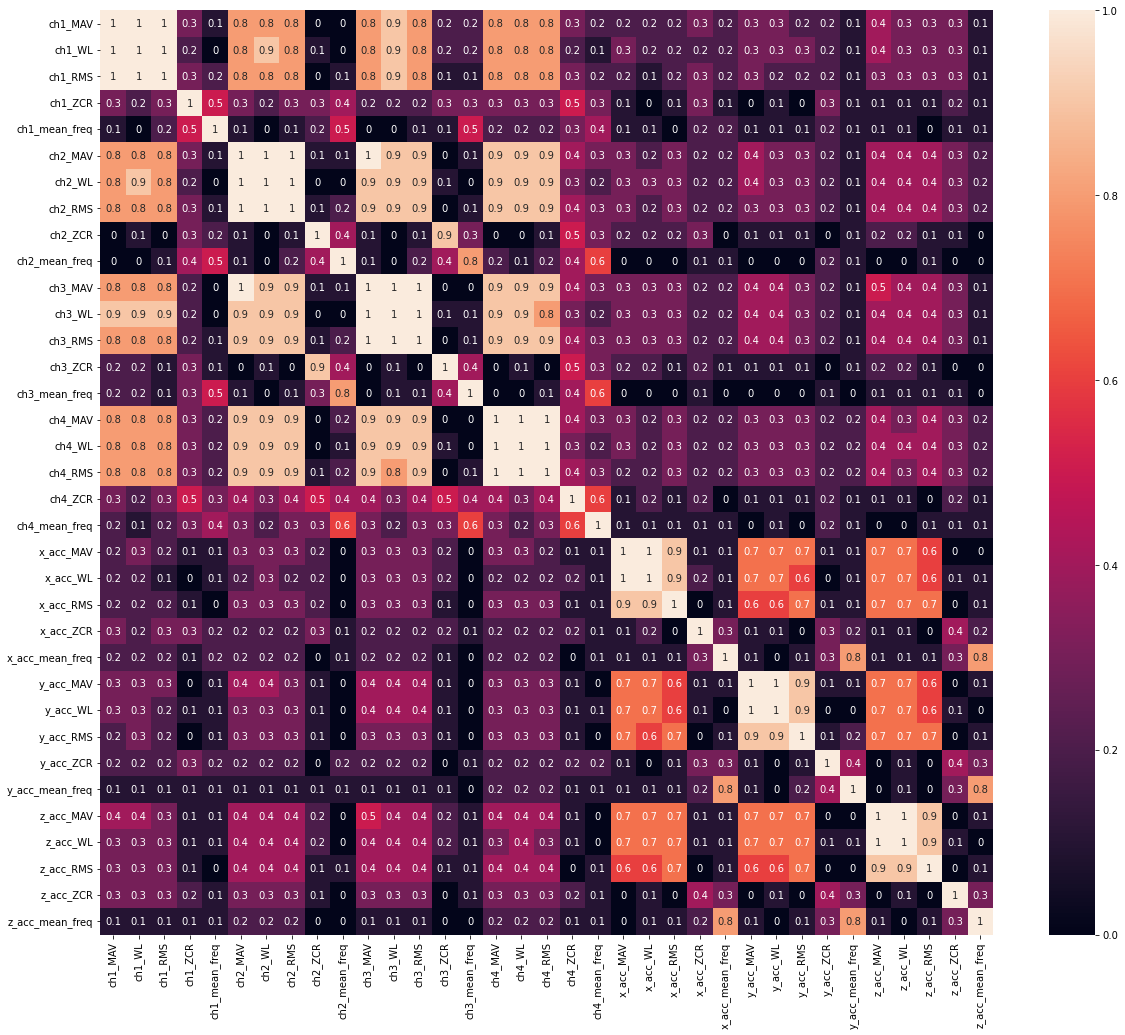

In [33]:
CorrMatrix = round(abs(data[features].corr()),1) #get absolute correlation matrix 
#(absolute because we do not mind about the sign of the correlation we just want to know the degree of correlation)

corr_name = "Figures/CorrMatrix_Model2.png"

#we can visualise this correlation matrix using heatmap (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
plt.figure(figsize=(20,17))
seaborn.heatmap(CorrMatrix, annot=True)
plt.savefig(corr_name, dpi=300)
plt.show()